In [502]:
import numpy as np
import pandas as pd
import pandas_ta as ta

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score , TimeSeriesSplit , RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
from sklearn.metrics import roc_curve , plot_roc_curve , plot_confusion_matrix , auc


import cufflinks as cf
cf.set_config_file(offline=True)
#https://github.com/santosjorge/cufflinks

import seaborn as sns
import plotly.graph_objs as go


import yfinance as yf

In [503]:
import yfinance as yf
import numpy as np

list_of_stock = [
    'ADVANC.BK', 'AOT.BK', 'AWC.BK', 'BANPU.BK', 'BBL.BK', 'BDMS.BK',
    'BEM.BK', 'BGRIM.BK', 'BH.BK', 'BJC.BK', 'BTS.BK', 'CBG.BK', 
    'CENTEL.BK', 'COM7.BK', 'CPALL.BK', 'CPF.BK', 'CPN.BK', 'CRC.BK',
    'DTAC.BK', 'EA.BK', 'EGCO.BK', 'GLOBAL.BK', 'GPSC.BK', 'GULF.BK',
    'HMPRO.BK', 'INTUCH.BK', 'IRPC.BK', 'IVL.BK', 'KBANK.BK', 'KTB.BK',
    'KTC.BK', 'LH.BK', 'MINT.BK', 'MTC.BK', 'OR.BK', 'OSP.BK', 'PTT.BK',
    'PTTEP.BK', 'PTTGC.BK', 'RATCH.BK', 'SAWAD.BK', 'SCB.BK', 'SCC.BK',
    'SCGP.BK', 'TISCO.BK', 'TMB.BK', 'TOA.BK', 'TOP.BK', 'TRUE.BK', 'TTB.BK'
]

# Weights for each financial ratio
weights = {
    'forwardPE': 0.25,
    'priceToBook': 0.25,
    'debtToEquity': 0.2,
    'returnOnEquity': 0.2,
    'currentRatio': 0.1
}

# Initialize min and max values
min_values = {
    'forwardPE': float('inf'),
    'priceToBook': float('inf'),
    'debtToEquity': float('inf'),
    'returnOnEquity': float('-inf'),
    'currentRatio': float('inf')
}
max_values = {
    'forwardPE': float('-inf'),
    'priceToBook': float('-inf'),
    'debtToEquity': float('-inf'),
    'returnOnEquity': float('inf'),
    'currentRatio': float('-inf')
}

# Fetch financial data and determine min/max values
for stock_symbol in list_of_stock:
    stock = yf.Ticker(stock_symbol)
    try:
        info = stock.info
        if all(key in info for key in weights.keys()):
            min_values['forwardPE'] = min(min_values['forwardPE'], info['forwardPE'])
            max_values['forwardPE'] = max(max_values['forwardPE'], info['forwardPE'])
            min_values['priceToBook'] = min(min_values['priceToBook'], info['priceToBook'])
            max_values['priceToBook'] = max(max_values['priceToBook'], info['priceToBook'])
            min_values['debtToEquity'] = min(min_values['debtToEquity'], info['debtToEquity'])
            max_values['debtToEquity'] = max(max_values['debtToEquity'], info['debtToEquity'])
            min_values['returnOnEquity'] = max(min_values['returnOnEquity'], info['returnOnEquity'])
            max_values['returnOnEquity'] = min(max_values['returnOnEquity'], info['returnOnEquity'])
            min_values['currentRatio'] = min(min_values['currentRatio'], info['currentRatio'])
            max_values['currentRatio'] = max(max_values['currentRatio'], info['currentRatio'])
    except KeyError:
        continue

def normalize(value, min_value, max_value):
    """Normalize the value to a range of 0 to 1."""
    return (value - min_value) / (max_value - min_value) if max_value != min_value else 1

best_score = float('-inf')
best_stock = None

for stock_symbol in list_of_stock:
    stock = yf.Ticker(stock_symbol)
    try:
        info = stock.info
        # Check if all required ratios are present
        if all(key in info for key in weights.keys()):
            pe_ratio = info['forwardPE']
            pb_ratio = info['priceToBook']
            de_ratio = info['debtToEquity']
            roe = info['returnOnEquity']
            current_ratio = info['currentRatio']
            
            # Normalize ratios for comparison
            normalized_pe = normalize(pe_ratio, min_values['forwardPE'], max_values['forwardPE'])
            normalized_pb = normalize(pb_ratio, min_values['priceToBook'], max_values['priceToBook'])
            normalized_de = 1 - normalize(de_ratio, min_values['debtToEquity'], max_values['debtToEquity'])
            normalized_roe = normalize(roe, min_values['returnOnEquity'], max_values['returnOnEquity'])
            normalized_current_ratio = normalize(current_ratio, min_values['currentRatio'], max_values['currentRatio'])
            
            # Calculate composite score
            score = (normalized_pe * weights['forwardPE'] +
                     normalized_pb * weights['priceToBook'] +
                     normalized_de * weights['debtToEquity'] +
                     normalized_roe * weights['returnOnEquity'] +
                     normalized_current_ratio * weights['currentRatio'])
            
            if score > best_score:
                best_score = score
                best_stock = stock
    except KeyError:
        # Skip if any required financial ratio is not available
        continue

if best_stock:
    print(best_stock.info['symbol'], best_score)
    print(best_stock.info['forwardPE'])
else:
    print("No stock found with valid financial ratios.")


In [504]:
# df1 = yf.download(best_stock.info['symbol'], start='2010-01-01' , end='2024-01-01')
df1 = yf.download('BH.bk', start='2010-01-01' , end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed


In [505]:
df1

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,29.50,30.25,29.50,29.75,22.404999,231800
2010-01-05,30.25,30.25,29.75,29.75,22.404999,524400
2010-01-06,30.50,30.50,29.75,30.00,22.593275,1105700
2010-01-07,30.25,30.50,30.00,30.50,22.969828,245700
2010-01-08,30.25,30.75,30.00,30.00,22.593275,293100
...,...,...,...,...,...,...
2023-12-22,217.00,218.00,214.00,216.00,213.015793,2276200
2023-12-25,216.00,217.00,215.00,216.00,213.015793,447900
2023-12-26,216.00,223.00,216.00,222.00,218.932907,3407800


In [506]:
df = df1.copy()
df['Forward Returns'] = np.log(df['Adj Close']).diff().shift(-1)
df

,Open,High,Low,Close,Adj Close,Volume,Forward Returns
Date,,,,,,,
2010-01-04,29.50,30.25,29.50,29.75,22.404999,231800,0.000000
2010-01-05,30.25,30.25,29.75,29.75,22.404999,524400,0.008368
2010-01-06,30.50,30.50,29.75,30.00,22.593275,1105700,0.016529
2010-01-07,30.25,30.50,30.00,30.50,22.969828,245700,-0.016529
2010-01-08,30.25,30.75,30.00,30.00,22.593275,293100,0.008299
...,...,...,...,...,...,...,...
2023-12-22,217.00,218.00,214.00,216.00,213.015793,2276200,0.000000
2023-12-25,216.00,217.00,215.00,216.00,213.015793,447900,0.027399
2023-12-26,216.00,223.00,216.00,222.00,218.932907,3407800,-0.009050


Drop Null

In [507]:
df.dropna(inplace=True)
df.isnull().sum()

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Forward Returns    0
dtype: int64

In [508]:
#features
#1. Moving Average 20 days cross 200 days
df['MA20'] = df['Adj Close'].rolling(window=20).mean()
df['MA200'] = df['Adj Close'].rolling(window=200).mean()
# if MA20 cross MA200 then 1 else 0
df['MA_Signal'] = np.where(df['MA20'] > df['MA200'], 1, 0)

#2. ohlc4
# df['OHLC4'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

#3. RSI
df['RSI'] = ta.rsi(df['Adj Close'], length=14)
df['RSI_Signal'] = np.where(df['RSI'] > 70, 1, 0)


# #5. Bullish divergence
# df['Bullish'] = np.where((df['Adj Close'] < df['Adj Close'].shift(1)) & (df['RSI'] > df['RSI'].shift(1)), 1, 0)

# #6. Bearish divergence
# df['Bearish'] = np.where((df['Adj Close'] > df['Adj Close'].shift(1)) & (df['RSI'] < df['RSI'].shift(1)), 1, 0)


# 7. MACD
macd = ta.macd(df['Adj Close'], fast=12, slow=26, signal=9)
df['MACD'] = macd['MACD_12_26_9']
df['MACD_Signal'] = macd['MACDs_12_26_9']
df['MACD_Hist'] = macd['MACDh_12_26_9']

#if MACD cross MACD Signal then 1 else 0
df['MACD_Signal_s'] = np.where(df['MACD'] > df['MACD_Signal'], 1, 0)

#8. Stochastic Oscillator
stoch = ta.stoch(high=df['High'], low=df['Low'], close=df['Close'], length=14)
df['%K'] = stoch['STOCHk_14_3_3'] #Blue if %K > 80 then overbought, if %K < 20 then oversold
df['%D'] = stoch['STOCHd_14_3_3'] #Red 
#if %K cross %D in the overbought area it is a sell signal, if %K cross %D in the oversold area it is a buy signal


#if %K cross %D then 1 else 0
df['Stoch_Signal'] = np.where(df['%K'] > df['%D'], 1, 0)

#9. Bollinger Bands
bbands = ta.bbands(df['Adj Close'], length=20)
df['BB_High'] = bbands['BBU_20_2.0']
df['BB_Low'] = bbands['BBL_20_2.0']



df.dropna(inplace=True)

In [509]:
df
# df.to_csv('stock.csv')

,Open,High,Low,Close,Adj Close,Volume,Forward Returns,MA20,MA200,MA_Signal,...,RSI_Signal,MACD,MACD_Signal,MACD_Hist,MACD_Signal_s,%K,%D,Stoch_Signal,BB_High,BB_Low
Date,,,,,,,,,,,,,,,,,,,,,
2010-10-27,34.25,34.75,34.00,34.00,26.324009,376300,0.000000,26.662739,23.777537,1,...,0,0.087536,0.207022,-0.119487,0,28.571429,31.746032,0,27.309063,26.016416
2010-10-28,34.00,34.25,33.75,34.00,26.324009,383000,0.014599,26.624028,23.797132,1,...,0,0.061127,0.177843,-0.116716,0,33.333333,30.158730,1,27.253912,25.994143
2010-10-29,33.75,34.50,33.75,34.50,26.711130,561800,-0.007273,26.604672,23.818662,1,...,0,0.070622,0.156399,-0.085777,0,35.714286,32.539683,1,27.197797,26.011547
2010-11-01,34.75,35.00,34.25,34.25,26.517574,364800,0.007273,26.575639,23.838284,1,...,0,0.061815,0.137482,-0.075667,0,37.301587,35.449735,1,27.124474,26.026803
2010-11-02,34.50,35.00,34.25,34.50,26.711130,729600,0.000000,26.594995,23.856990,1,...,0,0.069652,0.123916,-0.054265,0,44.444444,39.153439,1,27.134188,26.055801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,215.00,220.00,215.00,218.00,214.988159,1425200,-0.009217,214.889545,231.444194,0,...,0,-4.818062,-6.166971,1.348909,1,38.461538,44.444444,0,220.214940,209.564150
2023-12-22,217.00,218.00,214.00,216.00,213.015793,2276200,0.000000,214.593689,231.456475,0,...,0,-4.593065,-5.852190,1.259125,1,35.198135,39.083139,0,219.637709,209.549668
2023-12-25,216.00,217.00,215.00,216.00,213.015793,447900,0.027399,214.347143,231.483311,0,...,0,-4.364443,-5.554640,1.190198,1,40.839161,38.166278,1,219.189497,209.504788


In [510]:
# features = ['RSI','%K','%D','MA200','MA20'] not work
# features = ['RSI_Signal','MACD','MA_Signal'] not work
# features = ['%K','%D','MA_Signal','RSI_Signal','MACD_Signal'] not work
# features = ['%K','%D','RSI','RSI_Signal','MA200','MA20'] now work
# features = ['%K','%D','RSI','MACD','MACD_Signal','MACD_Hist','MA20','MA200','BB_High','BB_Low']
# features = ['%K','%D','RSI','MACD_Signal','MACD_Hist'] not work at
# features = ['%K','%D','RSI','MA20','MA200']


# features = ['%K','%D','RSI','RSI_Signal'] acc 0.55
#can you help me find the optimal feature the feature that i comment all above didnt work
# features = ['MA_Signal','RSI','MACD_Signal'] acc 0.52



features = ['%K','%D','RSI']

# features = ['%K','%D','RSI','RSI_Signal','MA200','MA20','MACD','MACD_Signal','MACD_Hist','BB_High','BB_Low'] shap ref.
# features = ['MA200','BB_Low','%D']







X = df[features].values
y = np.where(df['Forward Returns'] >= 0, 1, 0)

In [511]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2568, 3) (642, 3) (2568,) (642,)


In [512]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', RandomForestClassifier())
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model', RandomForestClassifier())])

In [513]:
y_pred = pipe.predict(X_test)

In [514]:
acc_train = accuracy_score(y_train, pipe.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {acc_train:.2f}')
print(f'Test Accuracy: {acc_test:.2f}')

Train Accuracy: 1.00
Test Accuracy: 0.53


Prediction Quality

118 156 147 221


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


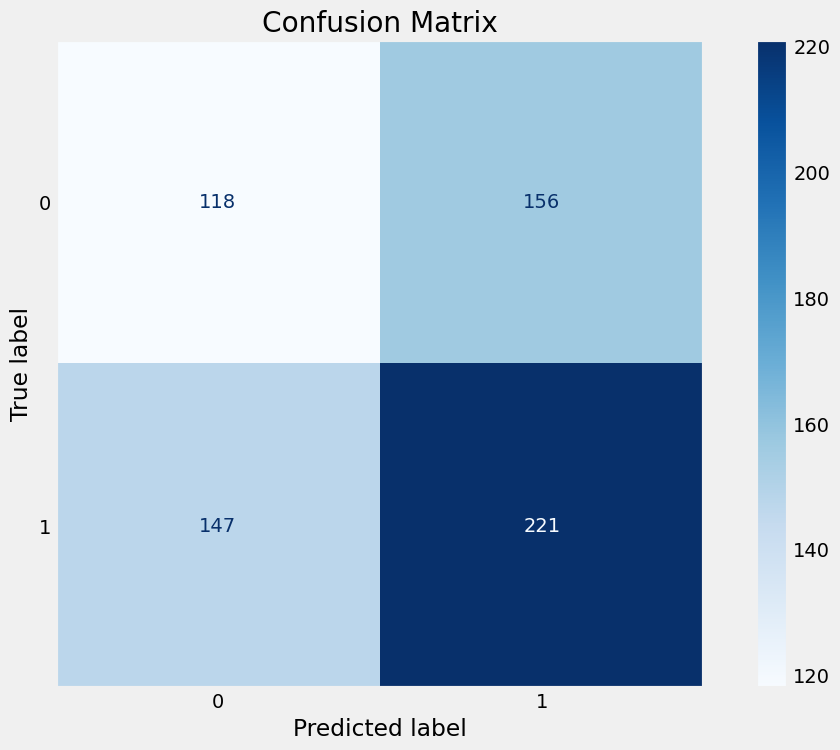

In [515]:
# Confusion Matrix for binary classification
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)

# Plot confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format='.4g')
plt.title('Confusion Matrix')
plt.grid(False)

In [516]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.43      0.44       274
           1       0.59      0.60      0.59       368

    accuracy                           0.53       642
   macro avg       0.52      0.52      0.52       642
weighted avg       0.53      0.53      0.53       642



Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


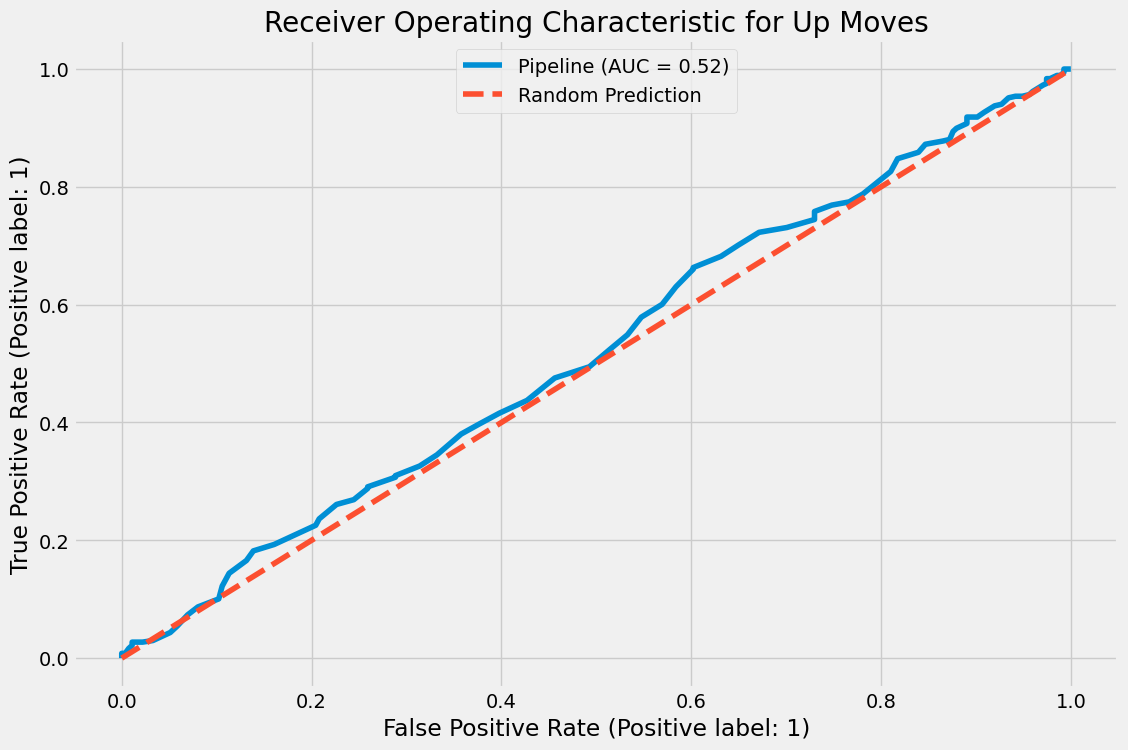

In [517]:
# Random Prediction
r_prob = [0 for _ in range(len(y_test))]
r_fpr, r_tpr, _ = roc_curve(y_test, r_prob, pos_label=1)

# Plot ROC Curve
plot_roc_curve(pipe, X_test, y_test)
plt.plot(r_fpr, r_tpr, linestyle='dashed', label='Random Prediction')
plt.title('Receiver Operating Characteristic for Up Moves')
plt.legend(loc=9)
plt.show()

In [518]:
# First 3 split
tscv = TimeSeriesSplit(n_splits=3, gap=1)
for train, test in tscv.split(X):
    print(train, test)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [519]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5, gap=1)

In [520]:
# Get parameters list
pipe.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('model', RandomForestClassifier())],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': RandomForestClassifier(),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__bootstrap': True,
 'model__ccp_alpha': 0.0,
 'model__class_weight': None,
 'model__criterion': 'gini',
 'model__max_depth': None,
 'model__max_features': 'auto',
 'model__max_leaf_nodes': None,
 'model__max_samples': None,
 'model__min_impurity_decrease': 0.0,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__min_weight_fraction_leaf': 0.0,
 'model__n_estimators': 100,
 'model__n_jobs': None,
 'model__oob_score': False,
 'model__random_state': None,
 'model__verbose': 0,
 'model__warm_start': False}

In [521]:
random_grid = {
    'model__n_estimators': list(range(100, 2000, 100)),
    'model__max_features': ['auto', 'sqrt', 'log2', None],
    'model__max_depth': list(range(10, 110, 10)) + [None],
    'model__min_samples_split': [2, 5, 10, 20, 30, 40],
    'model__min_samples_leaf': [1, 2, 7, 12, 14, 16, 20],
    'model__bootstrap': [True, False]
}

print(random_grid)

{'model__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900], 'model__max_features': ['auto', 'sqrt', 'log2', None], 'model__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'model__min_samples_split': [2, 5, 10, 20, 30, 40], 'model__min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'model__bootstrap': [True, False]}


In [522]:
# Perform Gridsearch and fit
grid_search = RandomizedSearchCV(pipe, random_grid, scoring='roc_auc', n_jobs=1, cv=tscv, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('model',
                                              RandomForestClassifier())]),
                   n_jobs=1,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__max_depth': [10, 20, 30, 40, 50,
                                                             60, 70, 80, 90,
                                                             100, None],
                                        'model__max_features': ['auto', 'sqrt',
                                                                'log2', None],
                                        'model__min_samples_leaf': [1, 2, 7, 12,
                                                                    14, 16,
                                                   

In [523]:
# Best Params
grid_search.best_params_

{'model__n_estimators': 800,
 'model__min_samples_split': 20,
 'model__min_samples_leaf': 20,
 'model__max_features': 'log2',
 'model__max_depth': 40,
 'model__bootstrap': True}

In [524]:
# Best Score
grid_search.best_score_

0.5200032204401455

In [525]:
# Extract best parameters and remove the 'model__' prefix
best_params = grid_search.best_params_
cleaned_best_params = {key.replace('model__', ''): value for key, value in best_params.items()}

# Create the RandomForestClassifier with the cleaned parameters
rand_frst_clf = RandomForestClassifier(**cleaned_best_params)

In [526]:
rand_frst_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, max_features='log2', min_samples_leaf=20,
                       min_samples_split=20, n_estimators=800)

In [527]:
imp_features = rand_frst_clf.feature_importances_
imp_features_pd = pd.Series(imp_features, index=df[features].columns)
imp_features_pd

%K     0.325390
%D     0.334024
RSI    0.340587
dtype: float64

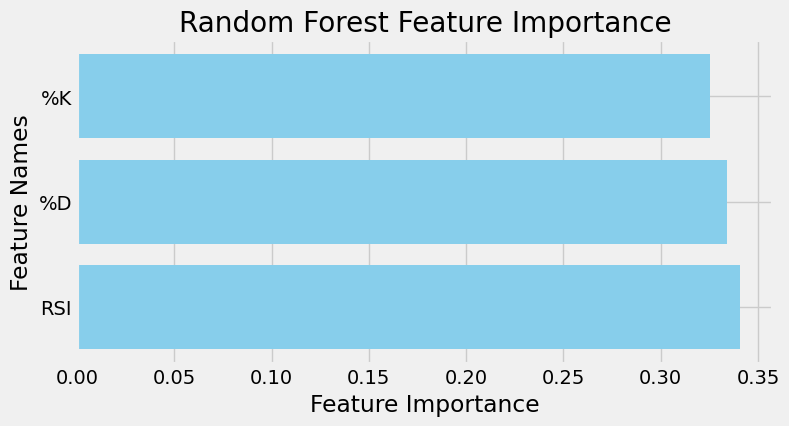

In [528]:
plt.figure(figsize=(8, 4))
plt.barh(imp_features_pd.index, imp_features_pd.values, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()

In [529]:
y_pred = rand_frst_clf.predict(X_test)

In [530]:
# Measure Accuracy
acc_train = accuracy_score(y_train, rand_frst_clf.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

In [531]:
# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t: {acc_test :0.4}')


 Training Accuracy 	: 0.6951 
 Test Accuracy 		: 0.5561


104 170 115 253


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


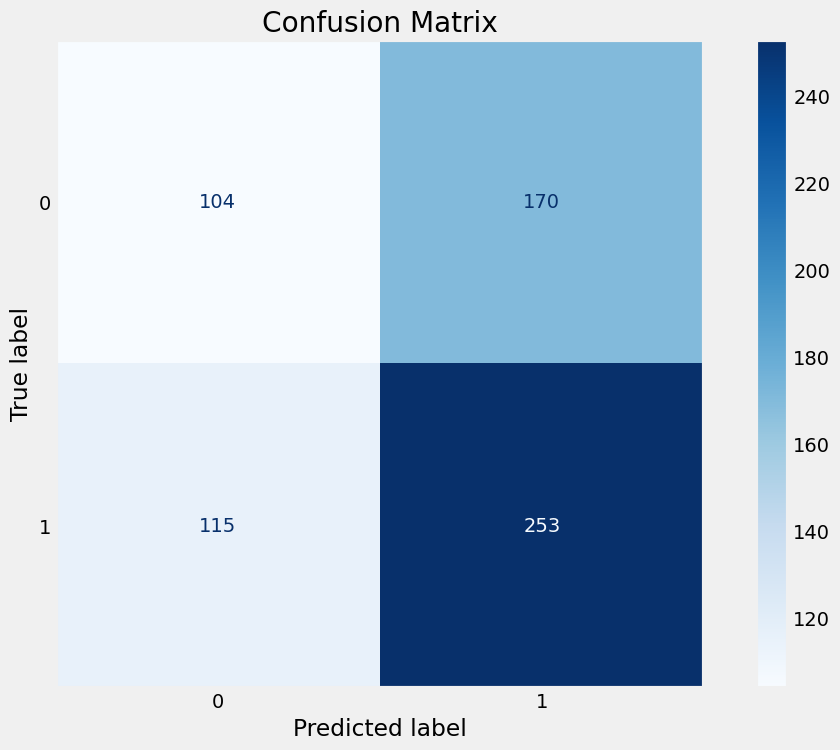

In [532]:
# Confusion Matrix for binary classification
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)

# Plot confusion matrix
plot_confusion_matrix(rand_frst_clf, X_test, y_test, cmap='Blues', values_format='.4g')
plt.title('Confusion Matrix')
plt.grid(False)

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


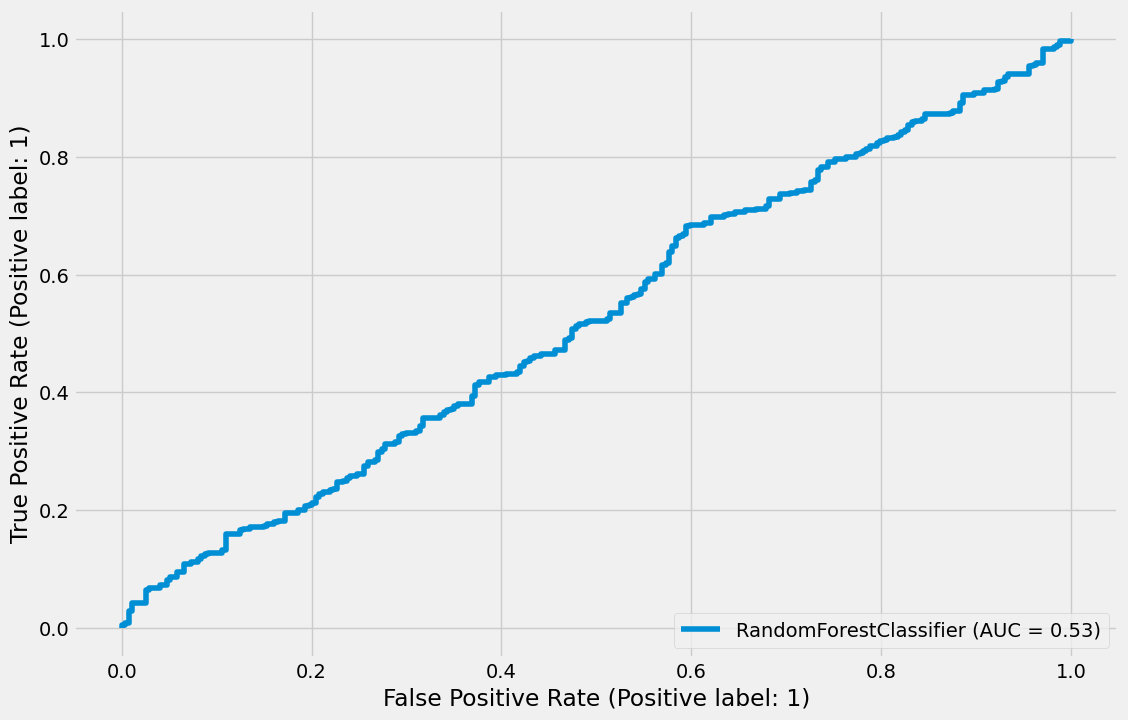

In [533]:
# Plot ROC Curve
plot_roc_curve(rand_frst_clf, X_test, y_test);

In [534]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.38      0.42       274
           1       0.60      0.69      0.64       368

    accuracy                           0.56       642
   macro avg       0.54      0.53      0.53       642
weighted avg       0.55      0.56      0.55       642



In [535]:
df1 = df.copy()
df1['Signal'] = rand_frst_clf.predict(X)

In [536]:
# Strategy Returns
df1['Strategy'] = df1['Forward Returns'] * df1['Signal'].fillna(0)

df1.index = pd.to_datetime(df1.index).tz_localize('utc')

In [537]:
df1

,Open,High,Low,Close,Adj Close,Volume,Forward Returns,MA20,MA200,MA_Signal,...,MACD_Signal,MACD_Hist,MACD_Signal_s,%K,%D,Stoch_Signal,BB_High,BB_Low,Signal,Strategy
Date,,,,,,,,,,,,,,,,,,,,,
2010-10-27 00:00:00+00:00,34.25,34.75,34.00,34.00,26.324009,376300,0.000000,26.662739,23.777537,1,...,0.207022,-0.119487,0,28.571429,31.746032,0,27.309063,26.016416,1,0.000000
2010-10-28 00:00:00+00:00,34.00,34.25,33.75,34.00,26.324009,383000,0.014599,26.624028,23.797132,1,...,0.177843,-0.116716,0,33.333333,30.158730,1,27.253912,25.994143,1,0.014599
2010-10-29 00:00:00+00:00,33.75,34.50,33.75,34.50,26.711130,561800,-0.007273,26.604672,23.818662,1,...,0.156399,-0.085777,0,35.714286,32.539683,1,27.197797,26.011547,1,-0.007273
2010-11-01 00:00:00+00:00,34.75,35.00,34.25,34.25,26.517574,364800,0.007273,26.575639,23.838284,1,...,0.137482,-0.075667,0,37.301587,35.449735,1,27.124474,26.026803,1,0.007273
2010-11-02 00:00:00+00:00,34.50,35.00,34.25,34.50,26.711130,729600,0.000000,26.594995,23.856990,1,...,0.123916,-0.054265,0,44.444444,39.153439,1,27.134188,26.055801,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21 00:00:00+00:00,215.00,220.00,215.00,218.00,214.988159,1425200,-0.009217,214.889545,231.444194,0,...,-6.166971,1.348909,1,38.461538,44.444444,0,220.214940,209.564150,1,-0.009217
2023-12-22 00:00:00+00:00,217.00,218.00,214.00,216.00,213.015793,2276200,0.000000,214.593689,231.456475,0,...,-5.852190,1.259125,1,35.198135,39.083139,0,219.637709,209.549668,1,0.000000
2023-12-25 00:00:00+00:00,216.00,217.00,215.00,216.00,213.015793,447900,0.027399,214.347143,231.483311,0,...,-5.554640,1.190198,1,40.839161,38.166278,1,219.189497,209.504788,1,0.027399


In [538]:
# Import pyfolio
import pyfolio as pf #type:ignore

In [539]:
#find the first date of testing data
y = df1.tail(len(X_test)).head(1).index[0]
first_date_of_x_test = y.strftime('%Y-%m-%d')
print(first_date_of_x_test)

2021-05-10


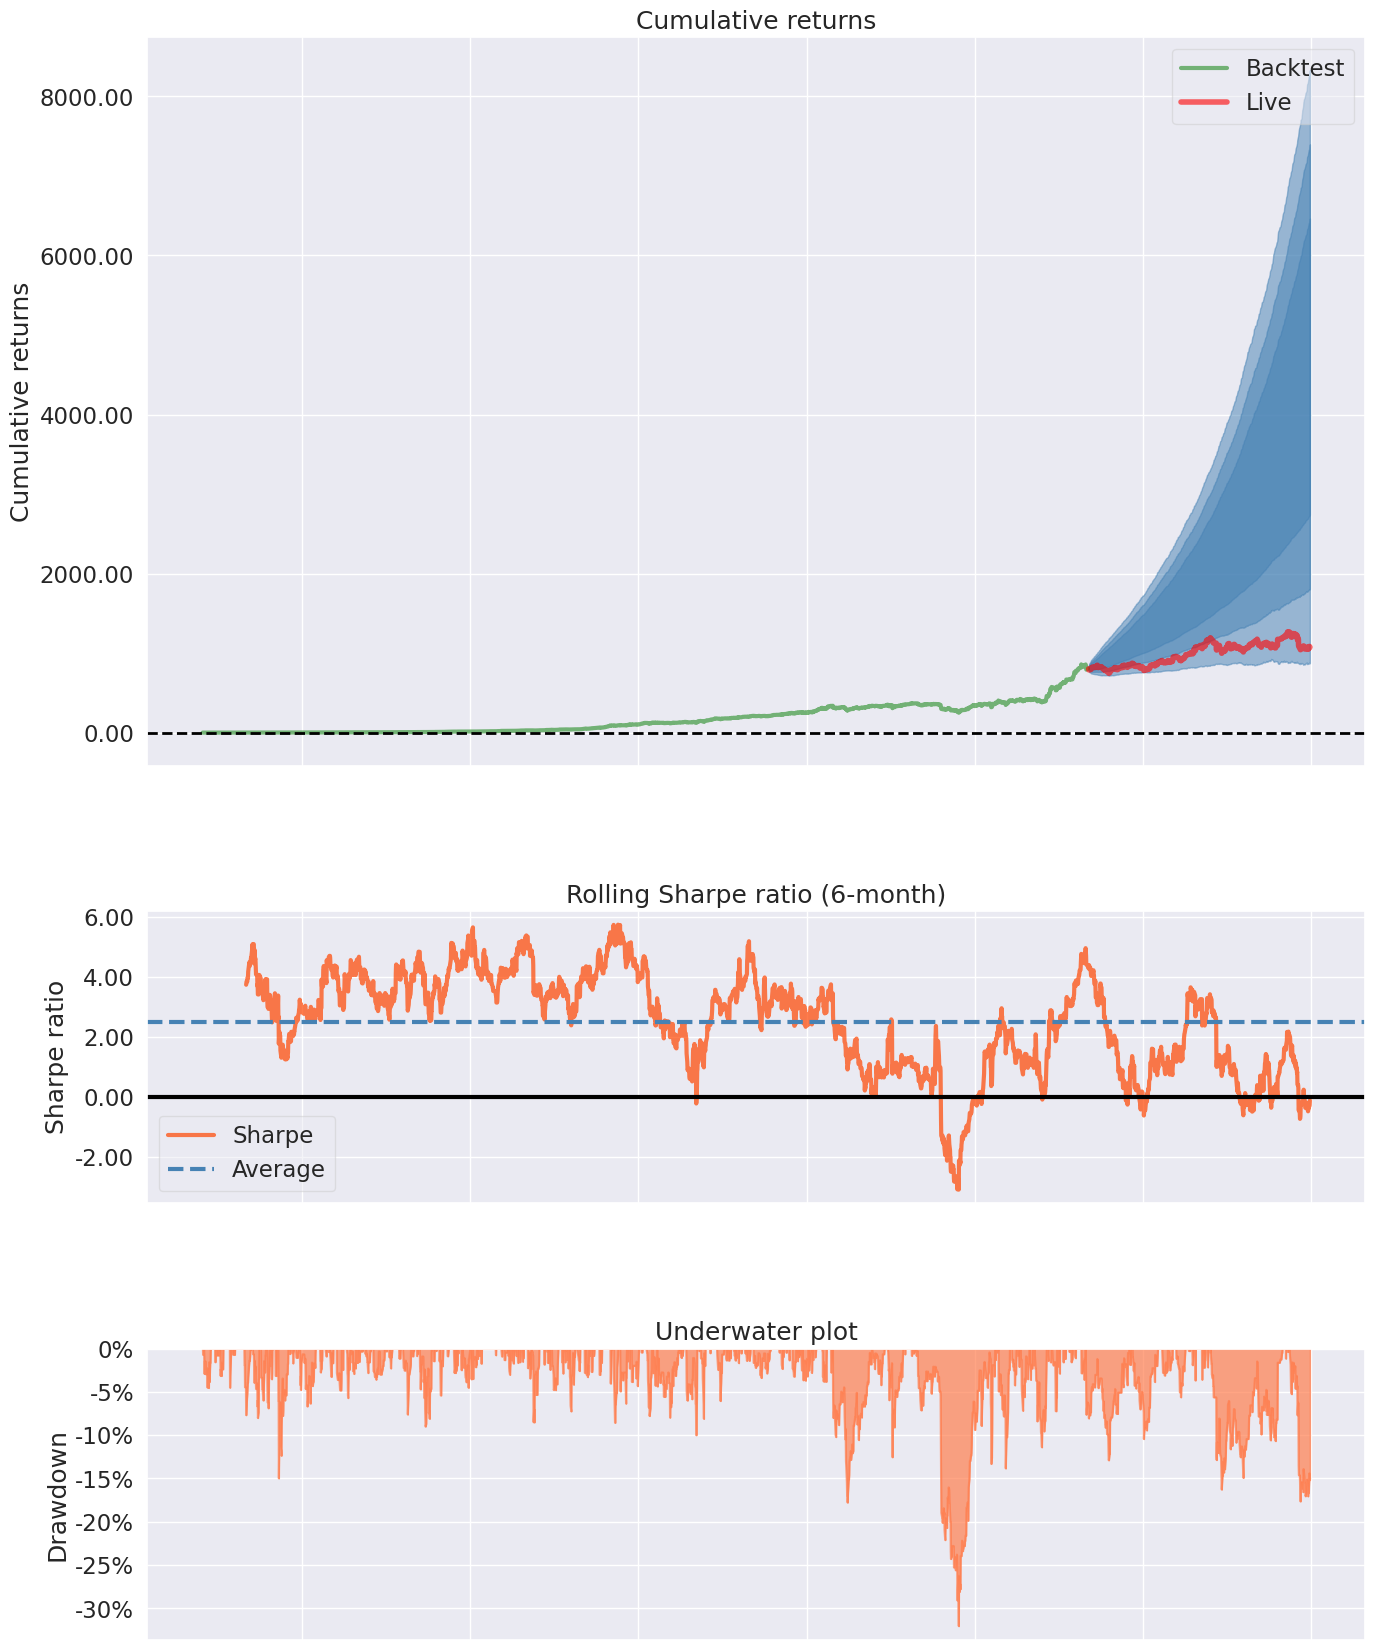

In [540]:
# Live start date first_date_of_x_test

pf.create_simple_tear_sheet(df1['Strategy'], live_start_date=first_date_of_x_test)

<AxesSubplot:title={'center':'Monthly returns (%)'}, xlabel='Month', ylabel='Year'>

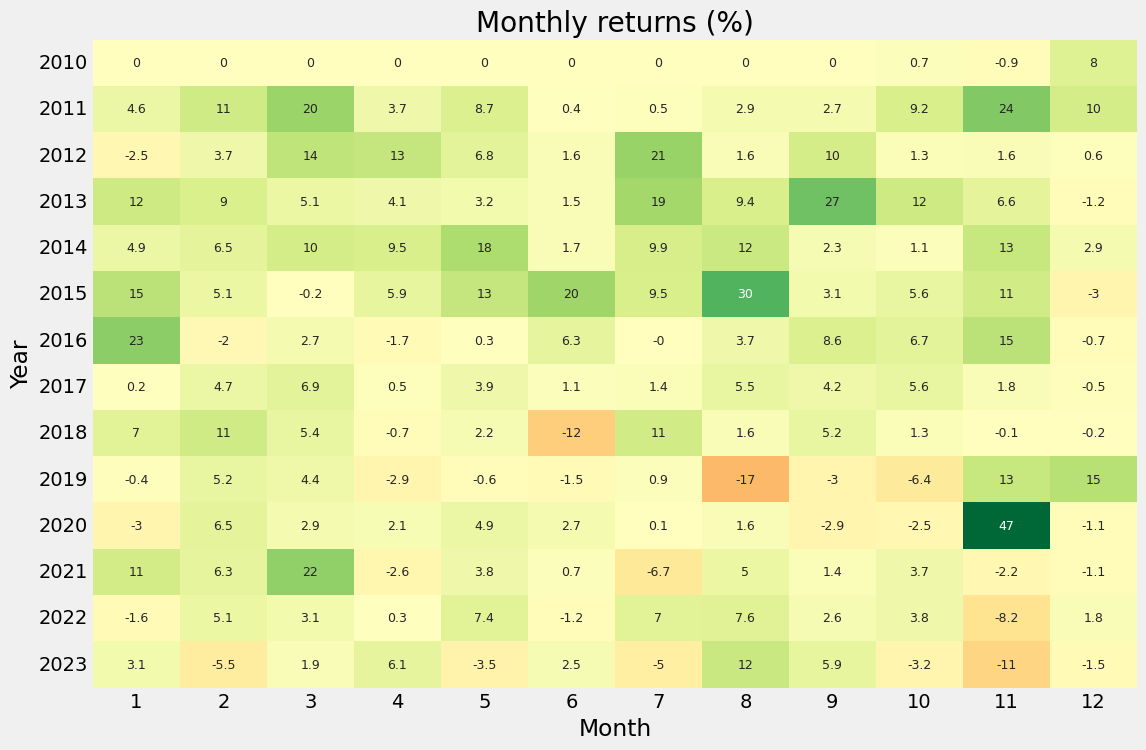

In [541]:
pf.plot_monthly_returns_heatmap(df1['Strategy'])

<AxesSubplot:title={'center':'Annual returns'}, xlabel='Returns', ylabel='Year'>

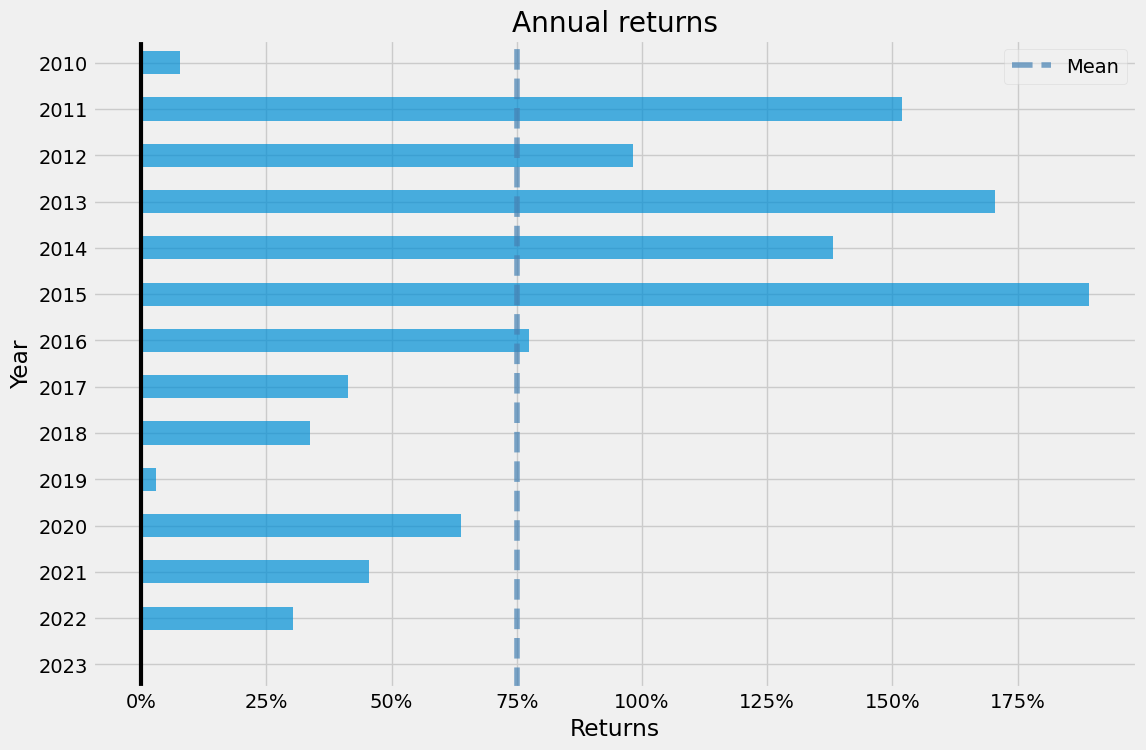

In [542]:
pf.plot_annual_returns(df1['Strategy'])

In [543]:
# import requests
# url = 'https://notify-api.line.me/api/notify'
# token = 'WT7cP5iu6O0XYJU3bO41CCC5TdfJoVSnfnEiTceBRCJ'
# headers = {'content-type':'application/x-www-form-urlencoded','Authorization':'Bearer '+token}

# msg = f'Best Stock: {best_stock.info["symbol"]}, Score: {best_score:.2f}, Test Accuracy: {acc_test:.2f}'
# r = requests.post(url, headers=headers, data = {'message':msg})
# print (r.text)

In [544]:
import shap
explainer = shap.Explainer(rand_frst_clf.predict, X_test)
shap_values = explainer(X_test)

Exact explainer: 643it [01:13,  7.47it/s]                         


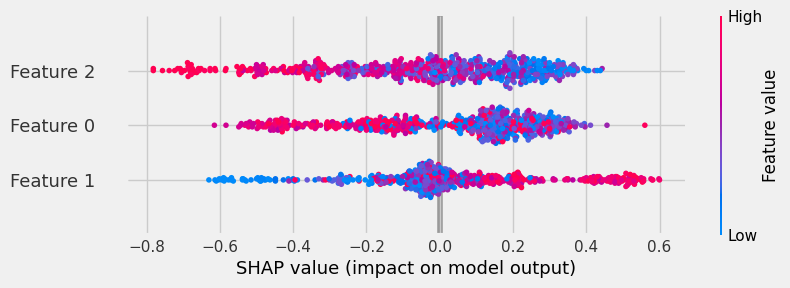

In [545]:
shap.plots.beeswarm(shap_values)

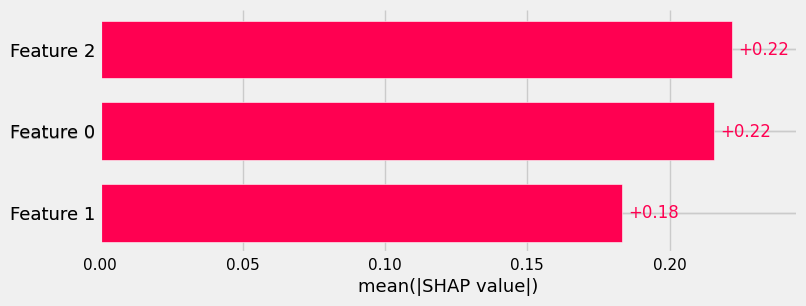

In [546]:
shap.plots.bar(shap_values)